In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

import tensorflow_model_optimization as tfmot

# Load Data and model

In [6]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
x_train = np.expand_dims(x_train, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32')
x_train = tf.image.resize(x_train, [32,32])

In [8]:
total = 6000

In [9]:
# input image dimensions
img_rows, img_cols = 32 ,32
input_shape = (img_rows, img_cols, 3)
input = tf.keras.Input(shape=input_shape)
efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

In [11]:
model_ = tf.keras.Model(efnet.input, output)
q_model = tfmot.quantization.keras.quantize_model(model_)
fp_model = tf.keras.Model(input, output)
fp_model.load_weights("../../weights/resnet_mnist_fp.h5")
q_model.load_weights("../../weights/resnet_mnist_q.h5")
fp_model.trainable = False
q_model.trainable = False
fp_model.compile()
q_model.compile()
preprocess = tf.keras.applications.resnet.preprocess_input
net = 'res'

In [15]:
attack_img = np.empty((0, 32, 32, 3))
for i in range(1, total+1):
    path = './results/resnet_mnist_images_second/second' + str(i) + '.npy'
    if os.path.exists(path):
        img = np.load(path)
        attack_img = np.concatenate((attack_img, [img]))
    if i % 50 == 0:
        print(i)
print(attack_img.shape)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
(5825, 32, 32, 3)


In [23]:
selected_attack_idx = []
for i,img in enumerate(attack_img):
    input_image = preprocess(img.copy())[None, ...]
    fp_pred = fp_model.predict(input_image)
    q_pred = q_model.predict(input_image)
    fp_label = np.argmax(fp_pred[0])
    q_label = np.argmax(q_pred[0])
    if q_label == 2 or q_label == fp_label or fp_label != 0 or q_label == 0 or fp_pred[0][fp_label] <= 0.6:
        selected_attack_idx.append(i)

In [30]:
attack_fil = np.empty((0, 32, 32, 3))
for i in range(1, total+1):
    path = './results/resnet_mnist_filters_second/second' + str(i) + '.npy'
    if os.path.exists(path) and os.path.exists('./results/resnet_mnist_images_second/second' + str(i) + '.npy'):
        img = np.load(path)
        attack_fil = np.concatenate((attack_fil, [img]))
print(attack_fil.shape)

(5825, 32, 32, 3)


In [32]:
thousand_selected_attack_idx = selected_attack_idx[:1000]

# Fetch sample images

In [19]:
fp_visual_model = tf.keras.models.Model(inputs = fp_model.input, outputs = fp_model.layers[-2].output)
q_visual_model = tf.keras.models.Model(inputs = q_model.input, outputs = q_model.layers[-2].output)

In [31]:
orig_img = attack_img - attack_fil
print(orig_img.shape)

(5825, 32, 32, 3)


In [33]:
orig_img_fp = np.empty((0,2048))
orig_img_q = np.empty((0,2048))
for i in thousand_selected_attack_idx:
    image = orig_img[i].copy()
    input_image = preprocess(image)[None, ...]
    fp = fp_visual_model.predict(input_image)
    q = q_visual_model.predict(input_image)
    orig_img_fp = np.concatenate((orig_img_fp, fp), axis=0)
    orig_img_q = np.concatenate((orig_img_q, q), axis=0)
    if i % 100 == 0:
        print(i)
        

0
200
300
400
600
1200
1400
1600
1700
1900
2100
2300


In [34]:
orig_img_fp.shape

(1000, 2048)

In [35]:
attack_img_fp = np.empty((0,2048))
attack_img_q = np.empty((0,2048))
num = 0
for i in thousand_selected_attack_idx:
    num += 1
    image = attack_img[i].copy()
    input_image = preprocess(image)[None, ...]
    fp = fp_visual_model.predict(input_image)
    q = q_visual_model.predict(input_image)
    attack_img_fp = np.concatenate((attack_img_fp, fp), axis=0)
    attack_img_q = np.concatenate((attack_img_q, q), axis=0)
    if num % 100 == 0:
        print(num)

100
200
300
400
500
600
700
800
900
1000


In [38]:
orig_img_fp.shape

(1000, 2048)

In [40]:
n = orig_img_fp.shape[0]
orig_2_img_fp = np.empty((0,2048))
orig_2_img_q = np.empty((0,2048))
for i, label in enumerate(y_train):
    if label == 2:
        input_image = preprocess(x_train[i].numpy())[None, ...]
        fp = fp_visual_model.predict(input_image)
        q = q_visual_model.predict(input_image)
        orig_2_img_fp = np.concatenate((orig_2_img_fp, fp), axis=0)
        orig_2_img_q = np.concatenate((orig_2_img_q, q), axis=0)
        if orig_2_img_fp.shape[0] >= n:
            break

In [41]:
images_all = np.concatenate((np.concatenate((orig_img_q, orig_img_fp),axis=0), orig_2_img_q), axis=0)

In [42]:
images_all = np.concatenate((np.concatenate((images_all, orig_2_img_fp),axis=0), attack_img_q), axis=0)

In [43]:
images_all = np.concatenate((images_all, attack_img_fp), axis=0)

In [44]:
labels = np.concatenate((np.concatenate((np.zeros((orig_img_q.shape[0])), np.ones((orig_img_fp.shape[0]))),axis=0), 2 * np.ones((orig_2_img_q.shape[0]))), axis=0)

In [45]:
labels = np.concatenate((np.concatenate((labels, 3*np.ones((orig_2_img_fp.shape[0]))),axis=0), 4 * np.ones((attack_img_q.shape[0]))), axis=0)

In [46]:
labels = np.concatenate((labels, 5*np.ones((attack_img_fp.shape[0]))), axis=0)

# PCA

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import decomposition

In [48]:
x = images_all

In [49]:
standardized_data = StandardScaler().fit_transform(x)
print(standardized_data.shape)

(6000, 2048)


In [50]:
# initializing the pca

pca = decomposition.PCA()


# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

shape of pca_reduced.shape =  (6000, 2)


In [51]:
import seaborn as sn
import pandas as pd
import matplotlib

In [52]:
# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, labels)).T

In [62]:
# save intermediate result
np.save('./pca_data.npy', pca_data)

In [11]:
pca_data = np.load('./pca_data.npy')

In [ ]:
pca_df = pd.DataFrame(data=pca_data, columns=("Principal Component 1", "Principal Component 2", "label"))

In [53]:
def scatter(x, y, **kwargs):
    label = float(kwargs['label'])
    if label == 5.0:
        plt.scatter(x, y, s=100, marker='X', color="tab:brown", cmap="tab10",label=label)
    elif label == 4.0:
        plt.scatter(x, y, s=100, marker='X', color="tab:purple", cmap="tab10", label=label)
    else:
        if label == 1.0:
            plt.scatter(x, y, s=100, marker='o', color="tab:orange", label=label)
        elif label == 2.0:
            plt.scatter(x, y, s=100, marker='o', color="tab:green", label=label)
        elif label == 0.0:
            plt.scatter(x, y, s=100, marker='o', c="tab:blue", label=label)
        else:
            plt.scatter(x, y, s=100, marker='o', c="tab:red", label=label)

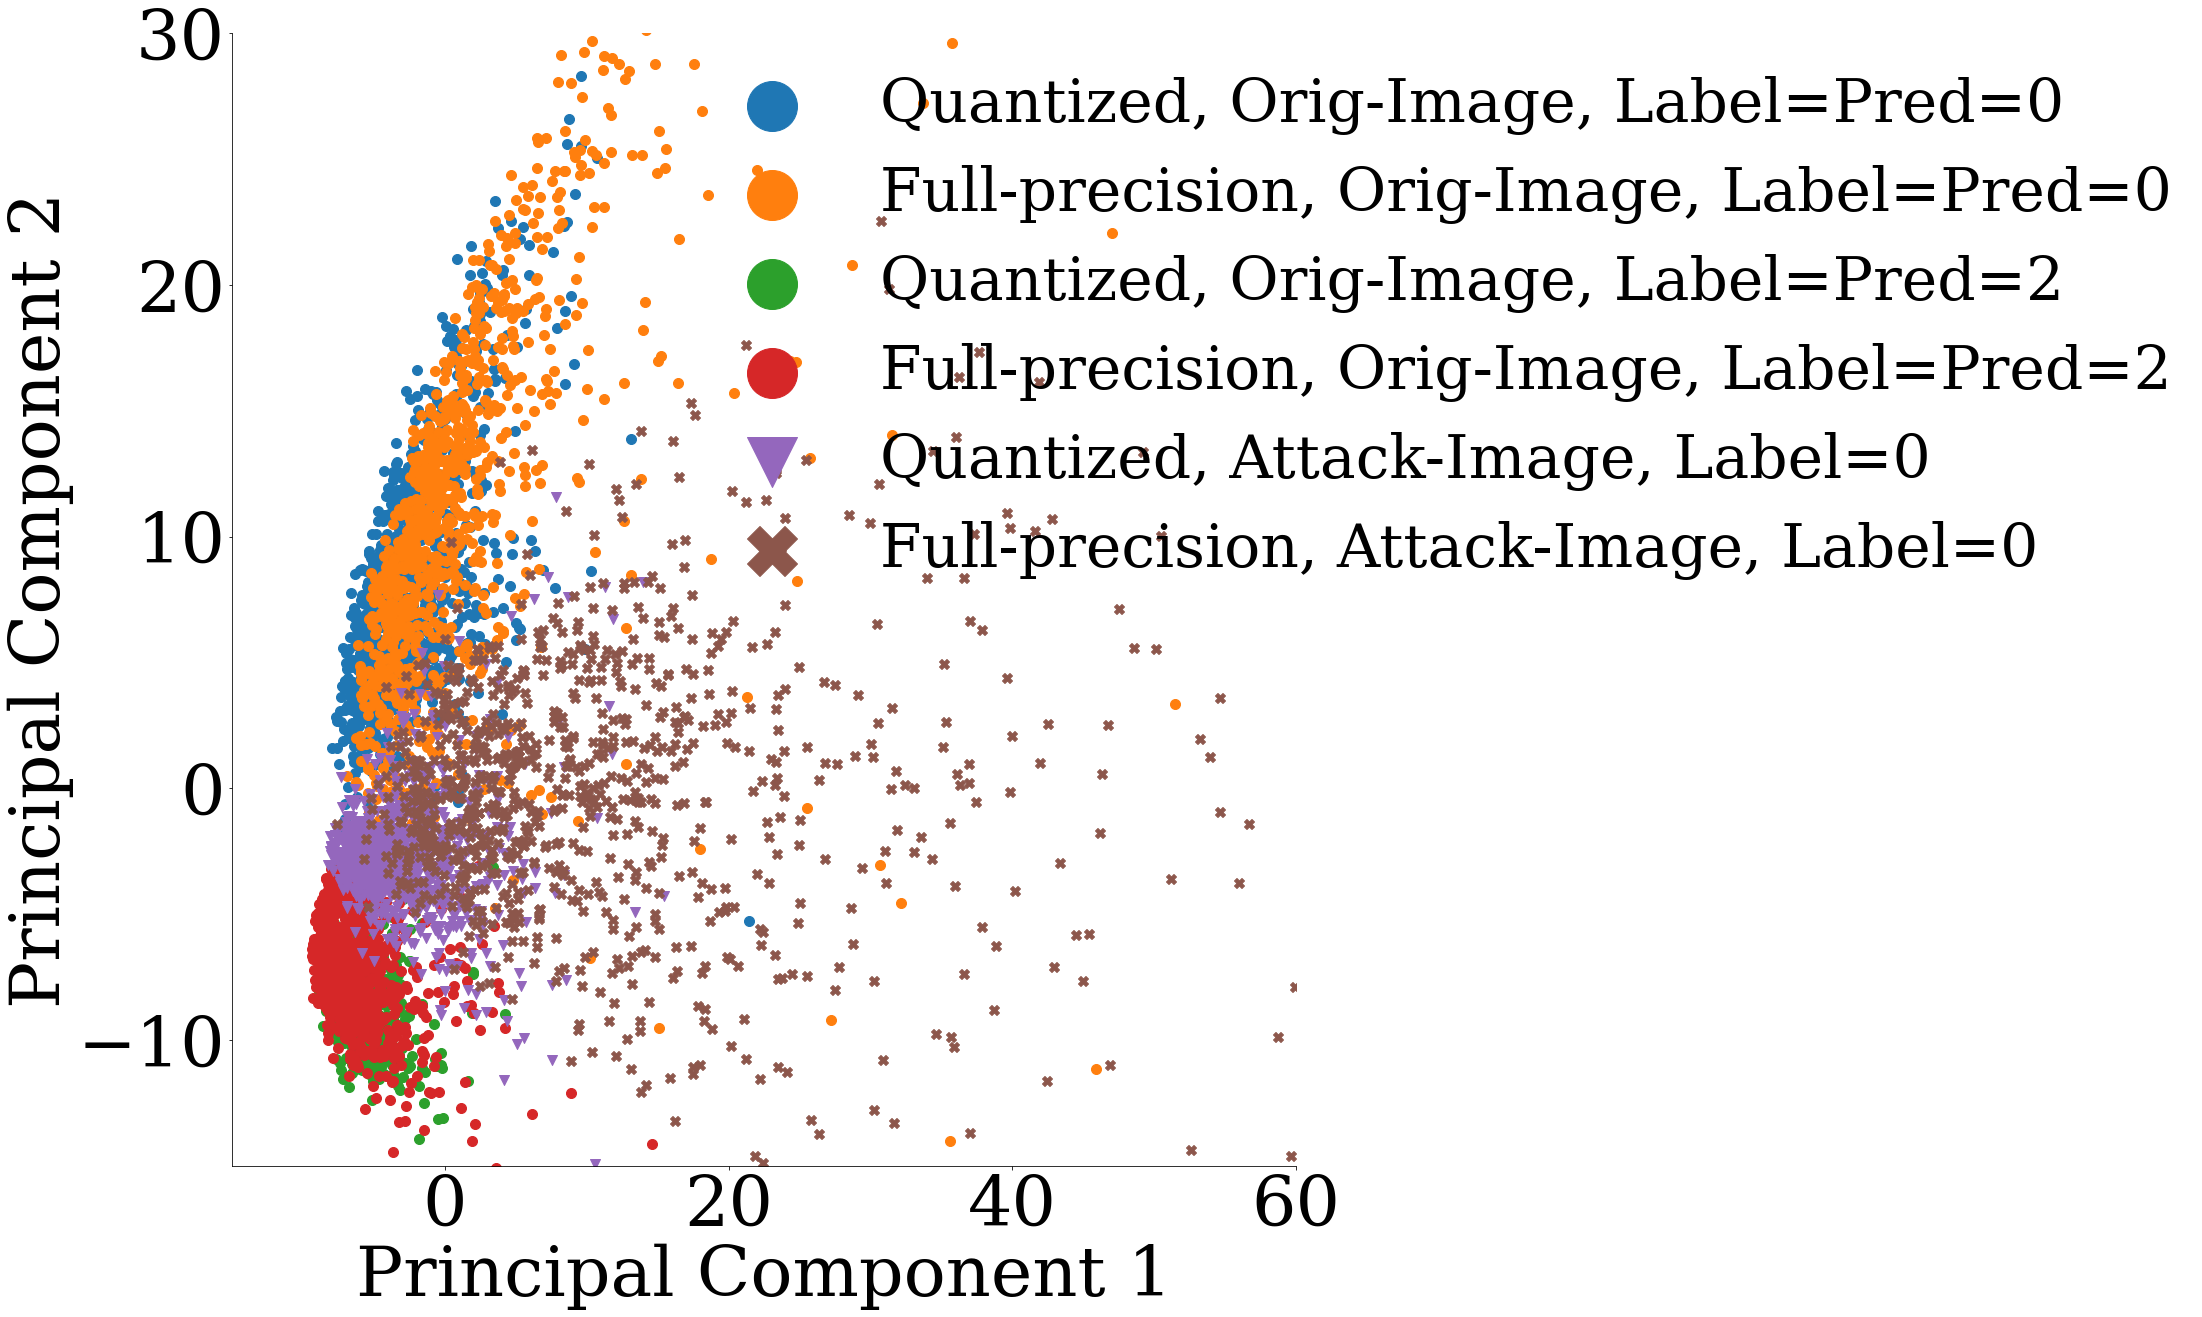

In [61]:
# creating a new data fram which help us in ploting the result data
palette=sn.color_palette("tab10",n_colors=6)
sn.FacetGrid(pca_df, hue="label", height=20, palette=palette).map(scatter, 'Principal Component 1', 'Principal Component 2')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman'] + plt.rcParams["font.serif"]
plt.rcParams["font.size"] = 70
plt.axis([-15, 60, -15, 30])
plt.legend(['Adapted, Orig-Image, Label=Pred=0', 'Orig-Model, Orig-Image, Label=Pred=0', 'Adapted, Orig-Image, Label=Pred=2', 'Orig-Model, Orig-Image, Label=Pred=2', 'Adapted, Attack-Image, Label=0', 'Orig-Model, Attack-Image, Label=0'], loc='upper left', bbox_to_anchor=(0.4, 1.01), frameon=False, markerscale=5, prop={'size': 60})
plt.savefig("PCA.pdf", dpi=100, bbox_inches="tight")
plt.show()

# t-SNE using Scikit-Learn

In [47]:
from sklearn.manifold import TSNE

In [421]:
#https://distill.pub/2016/misread-tsne/

model = TSNE(n_components=2, random_state=0, perplexity=5,  n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2)).T


# Ploting the result of tsne


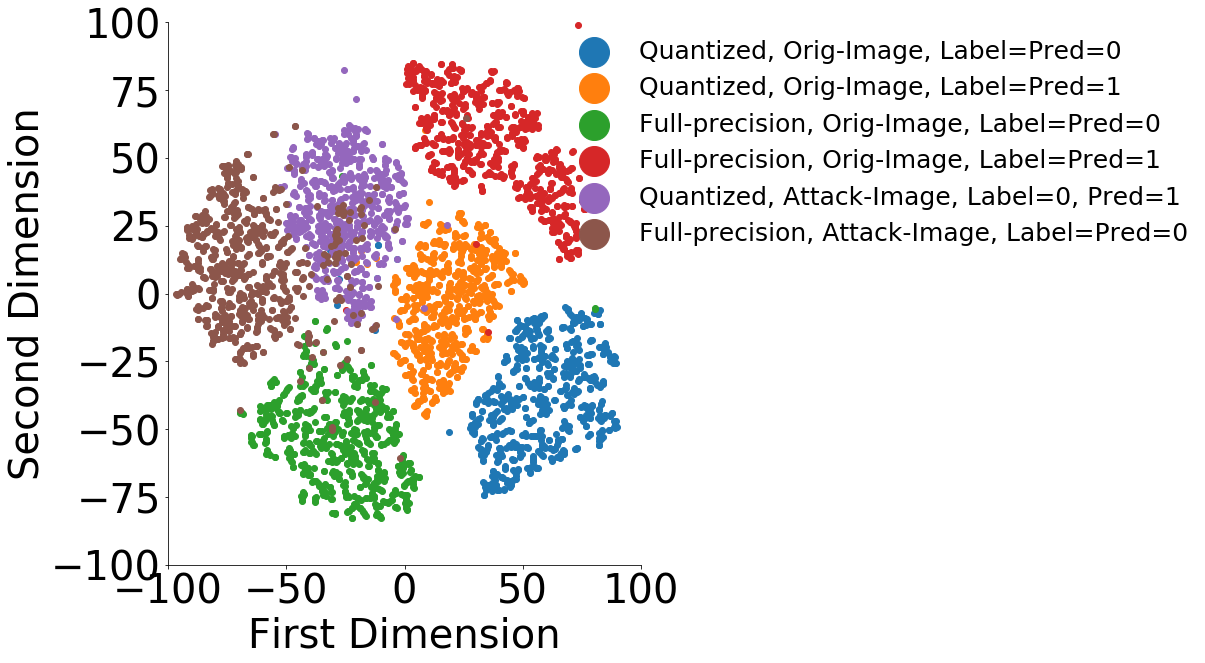

In [434]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("First Dimension", "Second Dimension", "label"))
sn.FacetGrid(tsne_df, hue="label", height=10).map(plt.scatter, 'First Dimension', 'Second Dimension')
plt.axis([-100, 100, -100, 100])
font = {'size': 30}
matplotlib.rc('font', **font)
plt.legend(['Quantized, Orig-Image, Label=Pred=0', 'Quantized, Orig-Image, Label=Pred=1', 'Full-precision, Orig-Image, Label=Pred=0', 'Full-precision, Orig-Image, Label=Pred=1', 'Quantized, Attack-Image, Label=0, Pred=1', 'Full-precision, Attack-Image, Label=Pred=0'],loc='upper left', bbox_to_anchor=(0.8, 1.01), frameon=False, markerscale=5, prop={'size': 25})
plt.show()

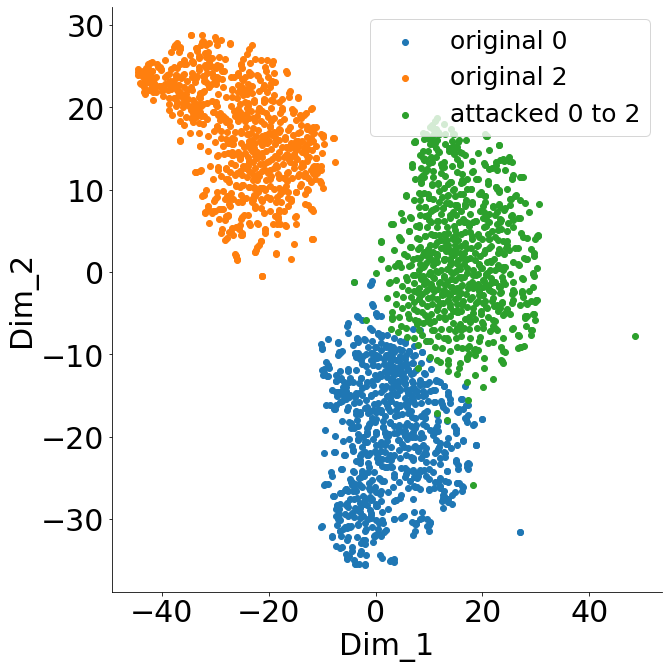

In [261]:
sn.FacetGrid(tsne_df, hue="label", height=10).map(plt.scatter, 'Dim_1', 'Dim_2')
plt.legend(['original 0', 'original 2', 'attacked 0 to 2', 'fp ori', 'fp gen'],loc=0, prop={'size': 25})
plt.show()